# Project: Investigate the "No Show Appointsments" Dataset  

## Table of Contents  
*   [Introduction](#intro)
*   [Data Wrangling](#wrangling)
*   [Exploratory Data Analysis](#eda)
*   [Conclusions](#conclusions)

<a id="intro"></a>
## Introduction  

The data set I have chosen to investigate is the "noshowappointments" dataset. I contains the data for over 110k medical appointments for patients in Brazil. The dataset was originally created to see if there were any factors that could help predict if the patients were going to miss their appointments.

The dataset contains patient demographic information, time frame information, and common factor information. The common factor information includes existing conditions, financial aid, and sms notifications.

## Questions:  

* Do age and gender play a role in whether a patient will make their appointment?  
* Does location play a role in missing an appointment?  
* Is time a factor? Can day of the week play a part?

In [1]:
# modules needed for working with  the data
import pandas as pd
import numpy as np
from datetime import date

# modules for the visualization
import matplotlib.pyplot as plt
import seaborn as sns

# added to show plots in the notebook
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling  


### General Properties  
The first step in the wrangling phase will be to load the data using Pandas' "read_csv" function.

In [2]:
filename = "https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv"
no_show_df = pd.read_csv(filename)

no_show_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


The ".info()" function shows basic useful stats for the dataset. The dataset contains over 110k entries. There are also no "null" entries, which will help lower the amount of data cleaning needed.  

The next step is to us ".head()" to show a sample of the dataset, and see how the data actually looks.

In [3]:
no_show_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No



### Data Cleaning  

The first step in the cleaning phase will be to use the ".describe()" function. This will show ranges and stats for each numerical column of the dataset.

In [4]:
no_show_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


After the use of ".head()" and ".describe()" a few issues jump out immediately:  
* "No shows" are represented as a string, and to do correlations they need to be numeric.
* The Age range goes from -1 to 115, this will need to be adjusted to a more realistic/standard range
* The "ScheduledDay" and "AppointmentDay" fields need to be changed into formats that are more useful.

The following steps were used to clean/format the data:

In [5]:
# Adding a clearer indicator of showing up
def show_up_converter(noshow):
    if noshow == 'Yes':
        return 1
    else:
        return 0
  
# Split out the date from the "ScheduledDay" and "AppointmentDay" fields 
def split_out_days(date_time):
    split_date_time = date_time.split("T")
    return split_date_time[0]

# Returns the number of days from a datetime object
def int_days(time_delta):
    return time_delta.days

# Returns a string value representing the weekday from a datetime object
def day_of_week(appt_day):
    weekday = appt_day.weekday()
    if weekday == 0:
        return 'Monday'
    elif weekday == 1:
        return 'Tuesday'
    elif weekday == 2:
        return 'Wednesday'
    elif weekday == 3:
        return 'Thursday'
    elif weekday == 4:
        return 'Friday'
    elif weekday == 5:
        return 'Saturday'
    elif weekday == 6:
        return 'Sunday'

#Adds new column for the integer value of a "no show"
no_show_df['No_Show_Int'] = no_show_df['No-show'].apply(show_up_converter)

# Adds new columns for the formatted dates
no_show_df['Sched_Day'] = no_show_df['ScheduledDay'].apply(split_out_days).apply(pd.to_datetime)
no_show_df['Appt_Day'] = no_show_df['AppointmentDay'].apply(split_out_days).apply(pd.to_datetime)

# Adds new column for the formatted string weekday
no_show_df['Appt_Day_of_Week'] = (no_show_df['AppointmentDay'].apply(split_out_days).apply(pd.to_datetime)).apply(day_of_week)

# Add new column representing the number of days from the schedule date to the appointment date
no_show_df['Time_Delta'] = (no_show_df['Appt_Day'] - no_show_df['Sched_Day']).apply(int_days)

# Removes patients younger than 0 years and over 100 years, 
# as they are either impossible or will add in outliers that could skew the results.
no_show_df = no_show_df[(no_show_df['Age'] >= 0) & (no_show_df['Age'] <= 100)]


<a id='eda'></a>
## Exploratory Data Analysis  

The main goal of this project is to see if any factor/set of factors correlates to a missed appointment. To do this a baseline must be established. The overall average of missed appointments will be the baseline. Anything significantly over this baseline could be a factor in missed appointments.


In [6]:
print(f"The average no show rate overall is {round((no_show_df['No_Show_Int'].mean() * 100), 2)}%.")

The average no show rate overall is 20.19%.



The next step will be to see if any single facors correlate to a missed appointment.

In [7]:
no_show_df.corr().iloc[:-2,-2]

PatientId       -0.001411
AppointmentID   -0.162585
Age             -0.060476
Scholarship      0.029147
Hipertension    -0.035677
Diabetes        -0.015172
Alcoholism      -0.000191
Handcap         -0.006382
SMS_received     0.126472
Name: No_Show_Int, dtype: float64

None of the fields have a particularly high correlation factor, so further examination must be done.  


### Research Question 1: Do age and gender play a role in whether a patient will make their appointment?    

The first step is to make a grouping function, as this will be used many times throughout the analysis.

In [8]:
# Groups data by a particular column and includes the average missed appointment rate,
# the total missed appointments, and the total overall appointments for the groups
def get_group_stats(input_df, grouping):
    grouping_stats = input_df.groupby(grouping)
    # by_grouping = grouping_stats.sum()['No_Show_Int']
    grouping_stats_df = pd.DataFrame()
    grouping_stats_df['mean_no_shows'] = (grouping_stats['No_Show_Int'].mean()).values
    grouping_stats_df['sum_no_shows'] = (grouping_stats['No_Show_Int'].sum()).values
    grouping_stats_df['total_appmt_count'] = (grouping_stats['No_Show_Int'].count()).values
    grouping_stats_df.index = (grouping_stats.sum()['No_Show_Int']).index.tolist()
    return grouping_stats_df


The next step is to check is age plays a significant part in the "no show" rate.

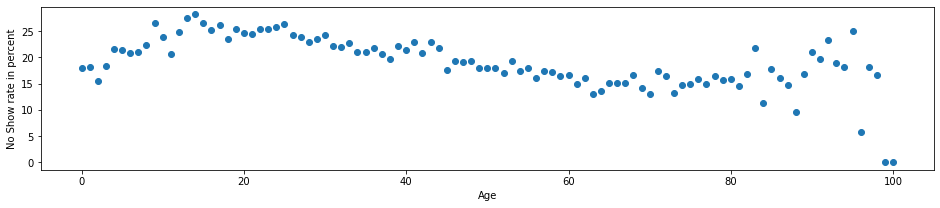

In [9]:
# grouping the data by age
age_stats_df = get_group_stats(no_show_df, 'Age')

# plotting the data and converting the mean to percentage
plt.figure(figsize=(16, 3))
plt.scatter(age_stats_df.index, (age_stats_df['mean_no_shows'])*100)
plt.xlabel("Age")
plt.ylabel("No Show rate in percent")
plt.show()

Most ages keep a close to the baseline "no show" average of 20.19%. However, there are slight peaks from 10-25 and 90-100. 

Now it is time to check gender stats.

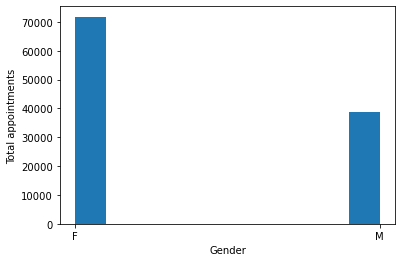

The average no show rate for mean is 19.97%.
The average no show rate for women is 20.31%.


In [10]:
# Shows amount of appointments for each gender
plt.hist(no_show_df['Gender'])
plt.xlabel("Gender")
plt.ylabel("Total appointments")
plt.show()

# Splits the data into each gender to help calculations
male_no_show_df = no_show_df[no_show_df['Gender'] == 'M']
female_no_show_df = no_show_df[no_show_df['Gender'] == 'F']
  
# Prints appointment "no show" averages for each gender
print(f"The average no show rate for mean is {round((male_no_show_df['No_Show_Int'].mean() * 100), 2)}%.")
print(f"The average no show rate for women is {round((female_no_show_df['No_Show_Int'].mean() * 100), 2)}%.")

Each gender has roughly the same percentage of "no shows", even though the number of total appointments by females is much higher.

The last step is to check if age combined with gender could be an indicator.

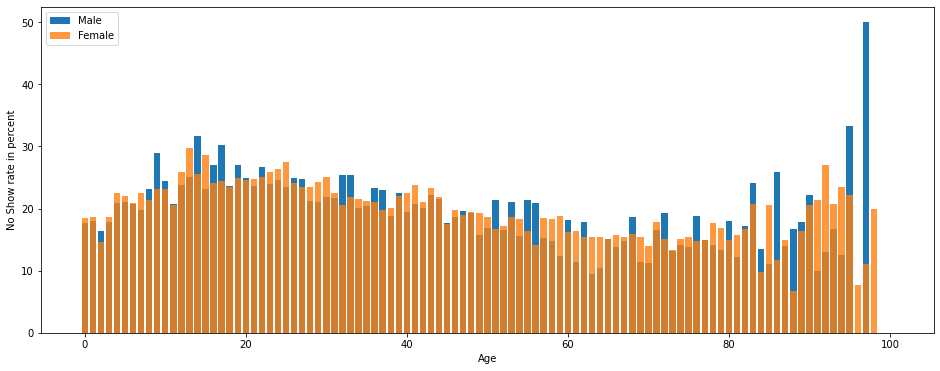

In [11]:
# Groups each gender by age
male_age_stats_df = get_group_stats(male_no_show_df, 'Age')
female_age_stats_df = get_group_stats(female_no_show_df, 'Age')

# Plots both genders across the age range and shows the average "no show" rate
plt.figure(figsize=(16, 6))
plt.bar(male_age_stats_df.index, (male_age_stats_df['mean_no_shows'])*100, label="Male")
plt.bar(female_age_stats_df.index, (female_age_stats_df['mean_no_shows'])*100, alpha=0.8, label="Female")
plt.legend()
plt.xlabel("Age")
plt.ylabel("No Show rate in percent")
plt.show()

The plot shows a very similar "no show" rate across all ages for both genders. The only large variation is the male rate spikes to 50% near the end of the range, but it seems to be an outlier instead of an indicator.

### Research Question 2: Does location play a role in missing an appointment?  

Grouping the data by location and taking out any outliers could help find an indicator.

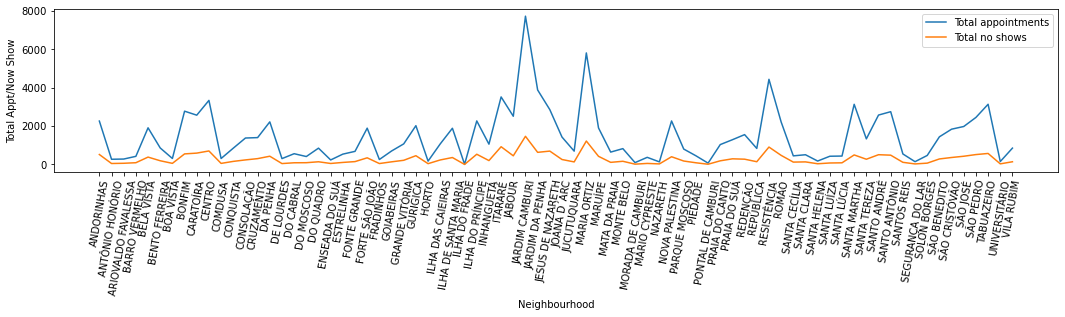

In [17]:
# Groups the data by location
loc_stats_df = get_group_stats(no_show_df, 'Neighbourhood')

# Removes the upper and lower 2.5% to keep everything within 3 standard deviations
loc_stats_df = loc_stats_df[loc_stats_df['mean_no_shows'] > loc_stats_df['mean_no_shows'].quantile(.025)]
loc_stats_df = loc_stats_df[loc_stats_df['mean_no_shows'] < loc_stats_df['mean_no_shows'].quantile(.975)]

# Shows a chart with both the total appointment count and total "no show count" for each neighbourhood
plt.figure(figsize=(18, 3))
plt.plot(loc_stats_df.index, (loc_stats_df['total_appmt_count']))
plt.plot(loc_stats_df.index, (loc_stats_df['sum_no_shows']))
plt.xticks(rotation = 80)
plt.legend(["Total appointments", "Total no shows"])
plt.xlabel("Neighbourhood")
plt.ylabel("Total Appt/No Show")
plt.show()


At first glance it looks like some of the neighbourhoods might have a higher rate of "no shows". Checking the average no show rate for each neighbourhood will help clarify if this is true.

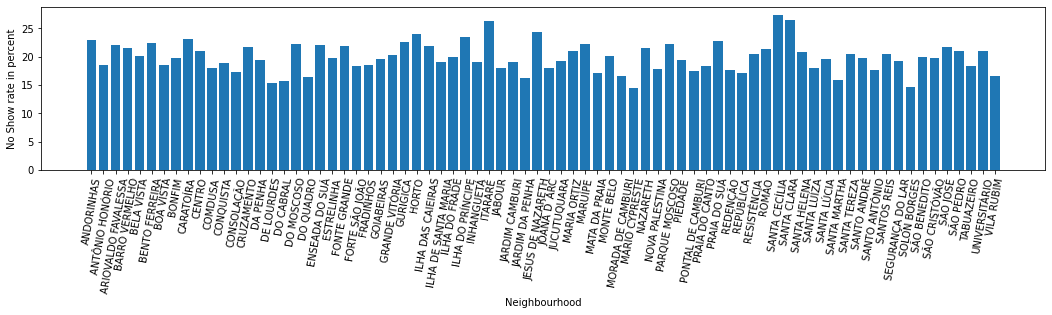

In [13]:
# Shows the average "no show" rate for each neighbourhood
plt.figure(figsize=(18, 3))
plt.bar(loc_stats_df.index, (loc_stats_df['mean_no_shows'])*100)
plt.xticks(rotation = 80)
plt.xlabel("Neighbourhood")
plt.ylabel("No Show rate in percent")
plt.show()

The rates are fairly consistent across the chart. Neighbourhoods do not seem to be an indicator of whether an appointment will be mised.

### Research Question 2: Is time a factor? Can day of the week play a part?  

Grouping by the time delta and the weekday could show possible indicators.

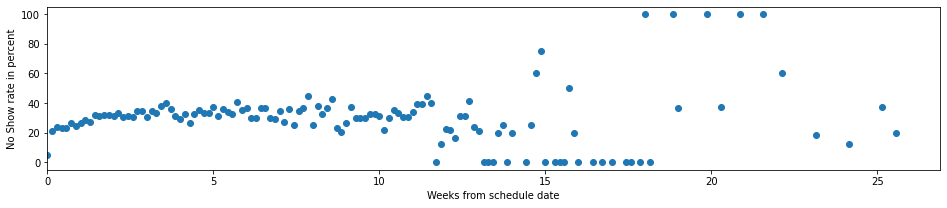

In [14]:
# Groups two new dataframes by time from schedule day to appointment day and the 
# day of the week the appoint is on
time_delta_stats_df = get_group_stats(no_show_df, 'Time_Delta')
day_week_stats_df = get_group_stats(no_show_df, 'Appt_Day_of_Week')

# Plots the average "no show" rate based on the time from schedule day to appointment day 
plt.figure(figsize=(16, 3))
plt.scatter((time_delta_stats_df.index / 7), ((time_delta_stats_df['mean_no_shows'])*100))
plt.xlim(xmin=0)
plt.xlabel("Weeks from schedule date")
plt.ylabel("No Show rate in percent")
plt.show()

There definitely seems to be a spike in no shows starting around week 17.

In [15]:
past_week_17 = no_show_df[no_show_df['Time_Delta'] > 17*7]
print(f"There are {past_week_17['No_Show_Int'].count()} appointments past week 17.")

x = round(((float(past_week_17['No_Show_Int'].count()))/(float(no_show_df['No_Show_Int'].count())))*100, 2)
print(f"These appointments only acount for {x}% of the total appointments.") 
print("This number is too low to count as an indicator for the dataset.")


There are 85 appointments past week 17.
These appointments only acount for 0.08% of the total appointments.
This number is too low to count as an indicator for the dataset.


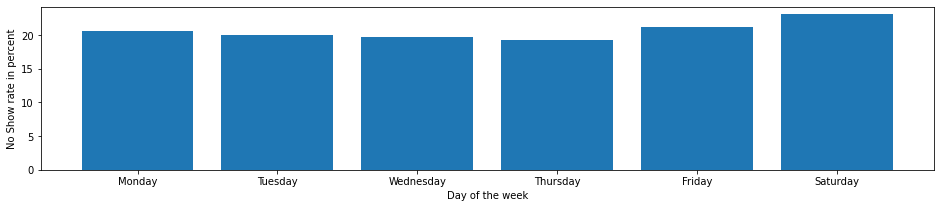

In [16]:
# Drops any week days where there were no appointments scheduled
day_week_stats_df = day_week_stats_df[day_week_stats_df['total_appmt_count'] > 0]

# Reindexes the data frame in the correct order
day_week_stats_df = day_week_stats_df.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Plots the average "no show" rate per week day
plt.figure(figsize=(16, 3))
plt.bar(day_week_stats_df.index, (day_week_stats_df['mean_no_shows'])*100)
plt.xlabel("Day of the week")
plt.ylabel("No Show rate in percent")
plt.show()


The "no show" rate is roughly the same regardless of the week day the appointment is scheduled on.

<a id='conclusions'></a>
## Conclusions  

None of the factors tested yeilded any significant inidcators of whether a patient would miss an appointment. This was expected as the original correlation calulcation did not show any factors with a high correlation to a "no show". While none of the factors tested yielded concrete results, other combinations of factors could. This will require further analyisis.

Suggested further testing:
* Whether SMS messages played a part, and how SMS messaging combined with other factors (age, gender, etc) might show a better correltaion
* Whether any of the conditions/situations listed () could be combined to  form a strong correlation.